# Clustering and Classifying Text

In [210]:
import pandas as pd
from pyclustering.cluster.clarans import clarans
from sklearn import metrics
from sklearn.cluster import  KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim import models
import spacy
import numpy as np

In [147]:
# Read CSV file into a DataFrame
file_path = 'Emotion_classify_Data.csv'
df = pd.read_csv(file_path)

# take only data not there classes
text_data = df['Comment'].tolist()

# Preprocessing function
def clean(data):
    return ''.join([i if ord(i) < 128 else ' ' for i in data])

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # disable for the size

my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

# nlp.max_length = len(text_data) + 1
doc = nlp(clean('\n'.join(text_data)))

# lemmatisation
texts, article, skl_texts = [], [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add to lemmatise version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        skl_texts.append(' '.join(article))
        texts.append(article)
        article = []


bi_gram = gensim.models.Phrases(texts)
texts = [bi_gram[line] for line in texts]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# TF-IDF of a Bi-gram
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

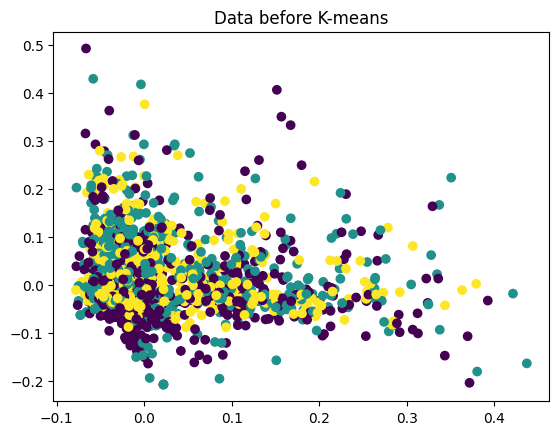

In [194]:
# show Scatter plot before K-means

# Convert Gensim corpus to a dense matrix (list of lists)
dense_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))

# PCA for dimensionality reduction
# PCA is used for dimensionality reduction, data visualization, and feature extraction
pca = PCA(n_components=2).fit(dense_matrix.T)
data2D = pca.transform(dense_matrix.T)
data2D = data2D[:3000]
# Scatter plot
categories = df['Emotion'].tolist()  # categories are 'Emotion'
categories = categories[:3000]
# Map string labels to numeric values
label_to_numeric = {'fear': 0, 'anger': 1, 'joy': 2}
numeric_labels = [label_to_numeric[label] for label in categories]
plt.scatter(data2D[:, 0], data2D[:, 1], c=numeric_labels)
plt.title('Data before K-means')
plt.show()


In [195]:
# La normalisation
n_components = 5  # top singular vectors to use in approximating the original data
svd = TruncatedSVD(n_components)
#  It is a technique used for linear dimensionality reduction. It decomposes a matrix into three other matrices and retains only the top singular vectors
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
dense = lsa.fit_transform(dense_matrix)
dense = dense[:3000]

## k-means

In [196]:
# K-means algorithm
true_k = np.unique(numeric_labels).shape[0]
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=42)

kmm = km.fit(dense)

In [220]:
# Top words per cluster
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

# Obtenez les termes du modèle TF-IDF Gensim
# Utilisez les termes du dictionnaire (bi-grammes)

# Boucle pour imprimer les termes pour chaque cluster
for i in range(true_k):
    print(f"Cluster : {i}")
    # Utilisez les termes du dictionnaire (bi-grammes)
    terms = [dictionary[word_id] for word_id in order_centroids[i, :5]]
    for term in terms:
        print(' %s' % term)


Cluster : 0
 horror
 remarkable
 tunji
 distract
 sit
Cluster : 1
 apparently
 obstacle
 zone
 abandonment
 exhausted
Cluster : 2
 provide
 moral
 manifest
 socially
 outweigh


In [198]:
# Evaluation du clustering
# Assuming km.labels_ is a numpy array or a list

print("Homogeneity: %0.5f" % metrics.homogeneity_score(categories, km.labels_))
print("Completeness: %0.5f" % metrics.completeness_score(categories, km.labels_))
print("V-measure: %0.5f" % metrics.v_measure_score(categories, km.labels_))
print("Adjusted Rand-Index: %0.5f" % metrics.adjusted_rand_score(categories, km.labels_))
print("Silhouette Coefficient: %0.5f" % metrics.silhouette_score(dense, km.labels_, sample_size=1000))

Homogeneity: 0.00024
Completeness: 0.00025
V-measure: 0.00025
Adjusted Rand-Index: -0.00032
Silhouette Coefficient: 0.22509


Text(0.5, 1.0, 'KMeans Clustering')

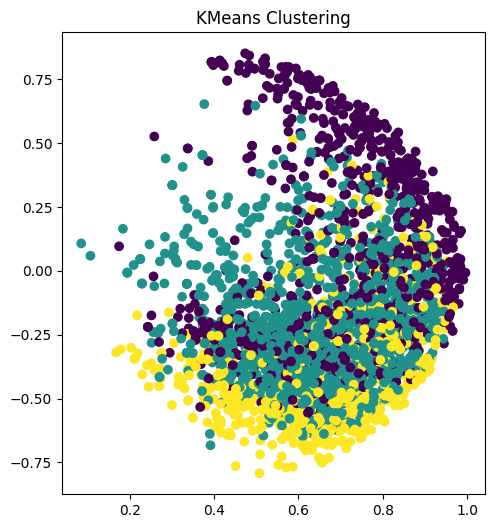

In [199]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(dense[:, 0], dense[:, 1], c=kmm.labels_, cmap='viridis', marker='o')
plt.title('KMeans Clustering')

## CLARANS

clustering algorithm designed for large datasets. It is an extension of the k-medoids algorithm
use a randomized search strategy.

In [200]:
clarans_instance = clarans(dense, 3, 2, maxneighbor=4)
clarans_instance.process()
clarans_clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

In [216]:
clarans_labels = np.zeros(len(categories))
for i in range(len(clarans_clusters)):
    for element in clarans_clusters[i]:
        clarans_labels[element] = i


In [219]:
# Top terms per cluster
for i, cluster in enumerate(clarans_clusters):
    print(f"Cluster {i}:")
    cluster_data = dense[cluster]

    # Calculate the centroid (average) of the cluster
    centroid = np.mean(cluster_data, axis=0)

    # Order terms by their importance in the centroid
    order_terms = np.argsort(centroid)[::-1]

    # Print the top terms for each cluster
    for j in range(5):
        term_index = order_terms[j]
        term = dictionary[term_index]
        print(f"  {term}")


Cluster 0:
  death
  hate
  feel
  reluctant
  drop
Cluster 1:
  death
  reluctant
  feel
  drop
  hate
Cluster 2:
  death
  drop
  feel
  hate
  reluctant


In [217]:
print("Homogeneity: %0.5f" % metrics.homogeneity_score(categories, clarans_labels))
print("Completeness: %0.5f" % metrics.completeness_score(categories, clarans_labels))
print("V-measure: %0.5f" % metrics.v_measure_score(categories, clarans_labels))
print("Adjusted Rand-Index: %0.5f" % metrics.adjusted_rand_score(categories, clarans_labels))
print("Silhouette Coefficient: %0.5f" % metrics.silhouette_score(dense, clarans_labels, sample_size=1000))

Homogeneity: 0.00031
Completeness: 0.00035
V-measure: 0.00033
Adjusted Rand-Index: -0.00027
Silhouette Coefficient: 0.20811


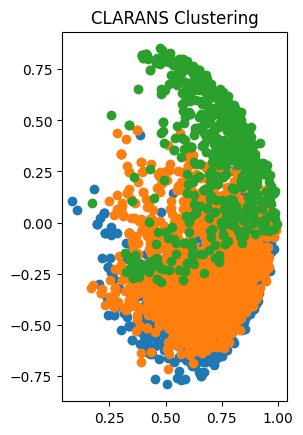

In [202]:
plt.subplot(1, 2, 2)
for idx, cluster in enumerate(clarans_clusters):
    plt.scatter(dense[cluster, 0], dense[cluster, 1], label=f'Cluster {idx}', marker='o')
plt.title('CLARANS Clustering')

plt.show()

### Observation

-> First of all , k-means faster than clarans.
-> Performers of Clarans are better than k-means.
-> Both of them are clustering data as we see in scatter plot.